# **Welcome to the Demo Notebook (*In Progress*)**

In this demo notebook we go through the `.py` modules used for the project and demonstrate their functionality.<br>


### **Step 1) The Dependencies**

The code for `package_installer` and the overall requirements module is taken from another DEDA quantlet, but amended to use pkg resources. Still, this part of the module requires more work and fine-tuning to be up-to-date with current standards. 

In [1]:
# Basic libraries
import re
import os
import gc
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### **Step 2) The Scraper**
Import the master_theses_scraper from the freshly added `thesis_scraper.py` module, docstring of which is given below. The function is constructed deliberately to produce many `print()` statements along the way to let the users know what stage of the work they are on and how this or that entry currently being processed looks like.

Also, to note, the scraping implementation is designed in a way that is specifically targeted at the HU website, meaning it will need some tinkering inside for repurposing. 


In [31]:
# Import the custom function and inspect
from thesis_scraper import master_theses_scraper 
master_theses_scraper?

Signature: master_theses_scraper(url, down_dir, headers)
Docstring:
Scrapes master's theses from a specified URL, retrieves download links, and downloads the theses.

Args:
    url (str): The URL of the webpage containing the LvB theses.
    down_dir (str): The directory where the scraped PDFs will be downloaded.
    headers (dict): HTTP headers to be used in the requests.
File:      d:\seafile\моя библиотека\2 semester\deda\github\bacha fork\deda_class_sose2023\deda_class_sose2023_lda_msc_theses\thesis_scraper.py
Type:      function

In [34]:
# Specify the link to scrape
url = 'https://www.wiwi.hu-berlin.de/de/forschung/irtg/lvb/research/dmb'

# Sets the directory for downloading our scraped pdfs
down_dir = 'OCRed PDFs/'

# Makes the directory in case it does not exist already
os.makedirs(down_dir, exist_ok = True)


# Set your own user agent here after ' User-Agent' Google: what is my user agent
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/113.0',
    'Accept-Language': 'en-US'
}

In [35]:
# Run the function:
master_theses_scraper(url = url,
                      down_dir = down_dir,
                      headers = headers
)

Scraping complete.
244 entries found.
An example entry in our links container looks like:
 <a data-linktype="external" data-val="https://edoc.hu-berlin.de/handle/18452/24455" href="https://edoc.hu-berlin.de/handle/18452/24455">Comparing Cryptocurrency Indices to Traditional Indices</a>


Identifying invalid links...
51 invalid links identified.
193 entries remain.
Identifying Master's Theses...
124 Master's Theses identified.
A sample entry looks as follows:
 <a href="https://edoc.hu-berlin.de/handle/18452/23881">App-based Forecasting of CRIX Index Returns Using R and R-Shiny</a>
Retrieving download links...
Due to missing link, dropped entry: <a href="http://edoc.hu-berlin.de/master/ristig-alexander-2012-02-03">Modelling of Vector MEM with Hierarchical Archimedean Copula</a>
Due to missing link, dropped entry: <a href="http://edoc.hu-berlin.de/master/schelisch-martin-2011-06-10">Jumps in High Frequency Data</a>
Due to missing link, dropped entry: <a href="http://edoc.hu-berlin.de/mast

## **Step 3) Pre-Processing**

1. The first thing that needs to be done is to check whether there are German language entries among our PDF files.
For this purpose, we have defined a function `de_detect` which takes as argument our directory and the files inside, scans them and removes the German entries.<br>

In [36]:
# Set folder as needed. 
folder = 'OCRed PDFs'
theses = os.listdir(folder) 


In [38]:
from lang_detect import de_detect

In [39]:
german_list = de_detect(folder, theses)

Current working directory: D:\Seafile\Моя библиотека\2 semester\DEDA\GitHub\Bacha fork\DEDA_class_SoSe2023\DEDA_class_SoSe2023_LDA_MSc_Theses
Currently working on 1.master_garcia_gonzalo.pdf_2021-08-26.
Currently working on 10.Masterarbeit_Bricke_Thomas.pdf_2019-06-27.
10.Masterarbeit_Bricke_Thomas.pdf_2019-06-27 was identified as German.
10.Masterarbeit_Bricke_Thomas.pdf_2019-06-27 removed from directory
Currently working on 100.wang.pdf_2005-09-15.
Currently working on 101.zeng.pdf_2005-09-14.
Currently working on 102.gillette.pdf_2005-09-13.
Currently working on 103.ignatieva.pdf_2005-09-06.
Currently working on 104.giacomini.pdf_2005-08-17.
Currently working on 105.du-moulinet-d-hardemare.pdf_2005-01-01.
Currently working on 106.sebe-vodislav.pdf_2009-08-13.
Currently working on 107.borak.pdf_2005-05-20.
Currently working on 108.andriyashin.pdf_2005-03-24.
Currently working on 109.chen.pdf_2005-02-06.
Currently working on 11.master_agakishiev_ilyas.pdf_2019-06-07.
Currently working

In [40]:
# These two lines included inside the function from now on
print(f'We have identified in total {len(german_list)} German language documents. See below the full list:')
print(german_list)

We have identified in total 7 German language documents. See below the full list:
['10.Masterarbeit_Bricke_Thomas.pdf_2019-06-27', '22.Masterarbeit_Frost_Oliver.pdf_2018-06-04', '60.jaehrling.pdf_2013-09-09', '87.myzickova.pdf_2007-11-14', '89.reichelt.pdf_2007-08-01', '93.ying.pdf_2007-02-22', '99.pari-schatz.pdf_2005-10-31']


In [41]:
# Clean memory
import gc
gc.collect()

531707

With $7$ papers dropped, that leaves the amount fo scraped papers at $114$, with additional $11$ sourced from CDs and scanning the physical documents.
So, we can proceed to work with the $125$ documents in total.<br>

2. Now we move on to the preprocessing part using the function `preprocess_text` from text_prep.py

What does the function do?

For every document in our directory it:
- makes text lower case
- removes non alphabetic characters
- removes stop words
- removes single-character words and other possible PDF reading mistakes
- lemmatizes words
- renders the processed theses as `.txt` files

This helps significantly reduce dimensions and get rid of noise in our data.

**Additional Functionality (Somewhat Costly):**

We have further included additional, but fairly computationally costly, funcitionality within the function that can be turned on by setting argument `verbose = True`.

Using this, the function will save and count the word tokens at every stage of the preprocessing and automately generate plots for additional insight into the dimensionality reduction process.


In [59]:
# Import function
from text_prep import preprocess_text

In [60]:
# See function arguments
preprocess_text?

Signature:
preprocess_text(
    first_input_folder=None,
    theses=None,
    inter_output_folder=None,
    verbose=False,
)
Docstring:
Preprocesses the PDF files by making everything lowercase,
getting rid of non-alphabetic words, removing stopwords,
tokenizing, lemmatizing, removing words with less than 3 character.

Args:
    first_input_folder (str): Path to the folder containing the PDF files.
    
    theses: os.listdir(folder).
            
    inter_output_folder (str): Intermediate output folder to save the filtered theses.
            
    verbose (bool): Returns vizualizations and information about dimensionality reduction. Can be set to False to save computational power, memory and time when working with large corpora of files.

Returns:
    None. Filthered theses saved in new folder.
File:      d:\seafile\моя библиотека\2 semester\deda\github\bacha fork\deda_class_sose2023\deda_class_sose2023_lda_msc_theses\text_prep.py
Type:      function

In [61]:
# Set folders as needed. 
first_input_folder = 'OCRed PDFs'
theses = os.listdir(first_input_folder) 
inter_output_folder = 'Filtered Theses'
os.makedirs(inter_output_folder, exist_ok = True)


Current working directory: D:\Seafile\Моя библиотека\2 semester\DEDA\GitHub\Bacha fork\DEDA_class_SoSe2023\DEDA_class_SoSe2023_LDA_MSc_Theses
Currently working on 1.master_garcia_gonzalo.pdf_2021-08-26.
Currently working on 100.wang.pdf_2005-09-15.
Currently working on 101.zeng.pdf_2005-09-14.
Currently working on 102.gillette.pdf_2005-09-13.
Currently working on 103.ignatieva.pdf_2005-09-06.
Currently working on 104.giacomini.pdf_2005-08-17.
Currently working on 106.sebe-vodislav.pdf_2009-08-13.
Currently working on 107.borak.pdf_2005-05-20.
Currently working on 108.andriyashin.pdf_2005-03-24.
Currently working on 109.chen.pdf_2005-02-06.
Currently working on 11.master_agakishiev_ilyas.pdf_2019-06-07.
Currently working on 110.detlefsen.pdf_2005-01-27.
Currently working on 111.benko.pdf_2004-12-20.
Currently working on 112.ulbricht.pdf_2004-08-27.
Currently working on 114.zhou.pdf_2004-07-06.
Currently working on 115.mungo.pdf_2004-05-17.
Currently working on 116.giacomini.pdf_2003-12-

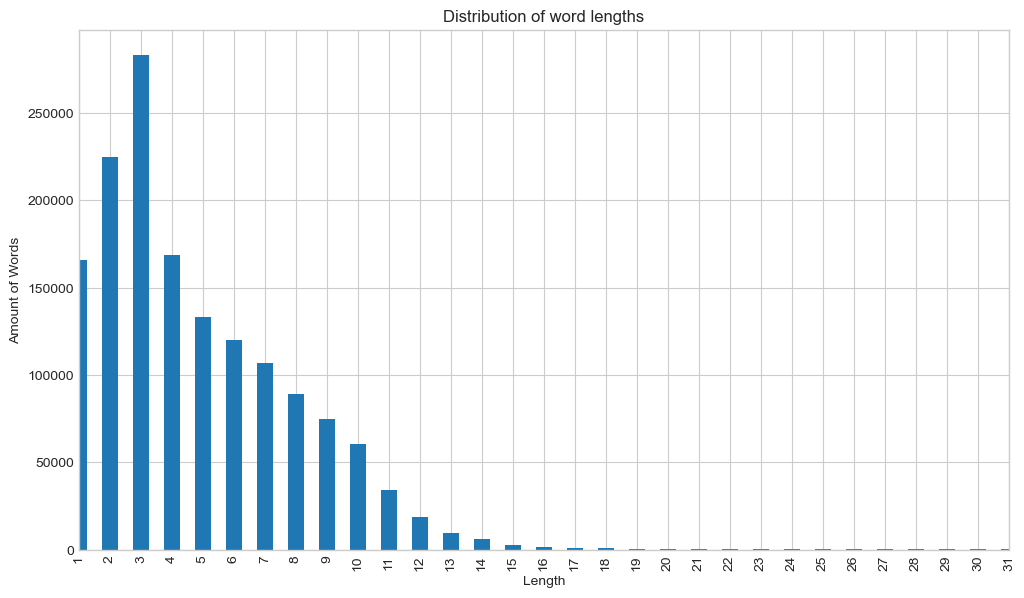



Total amount of words before dropping single character words: 1515140 




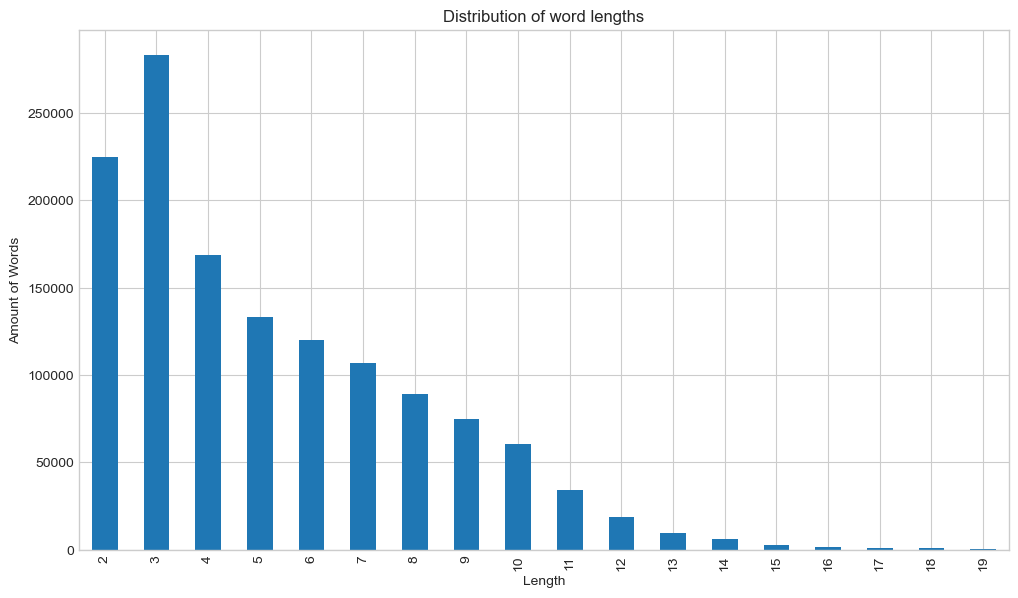



Total amount of words after dropping single character words and other pdf reader mistakes: 1336265 




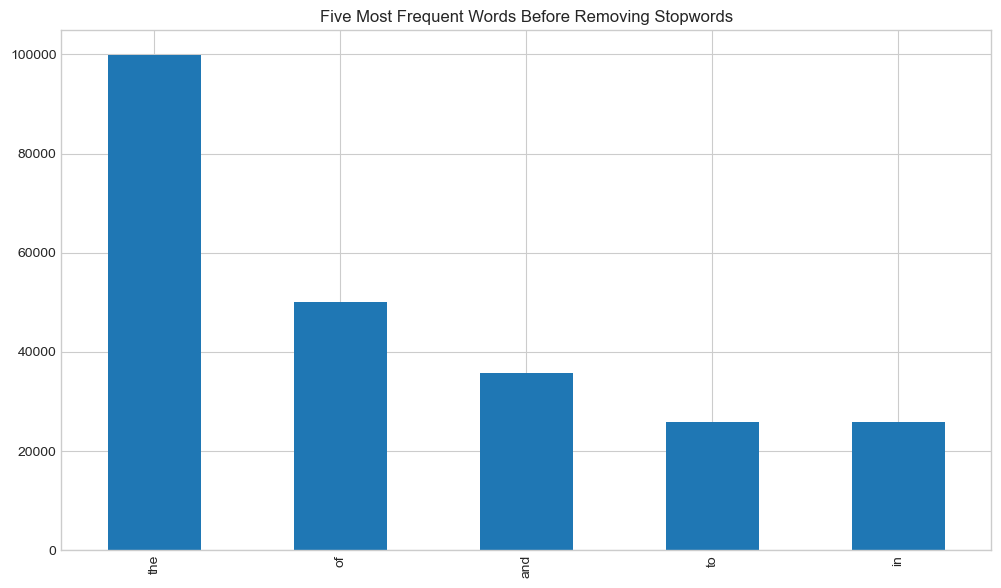



Total amount of words before removing stopwords: 1336265




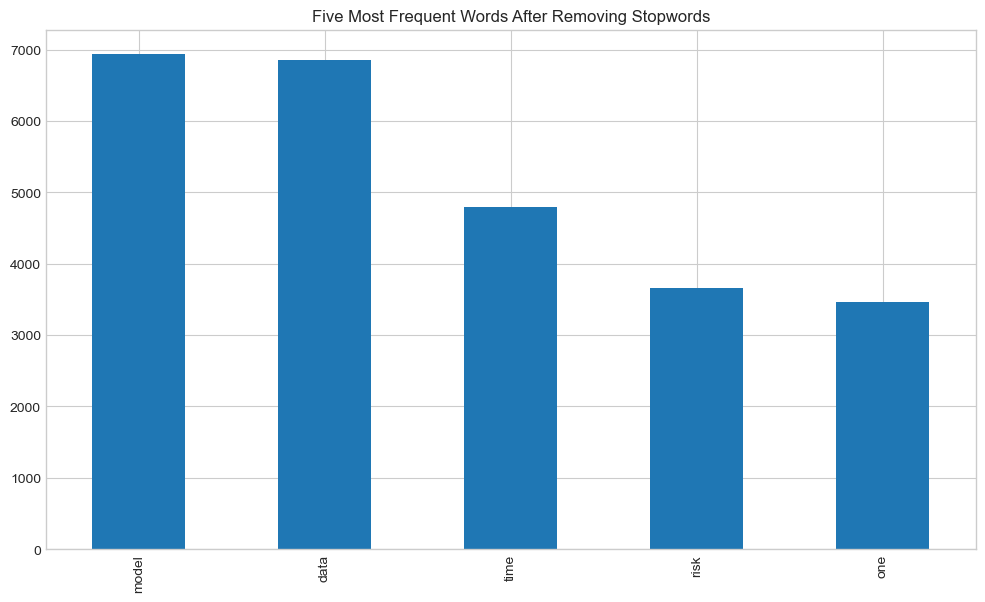



Total amount of words after removing stopwords: 823147




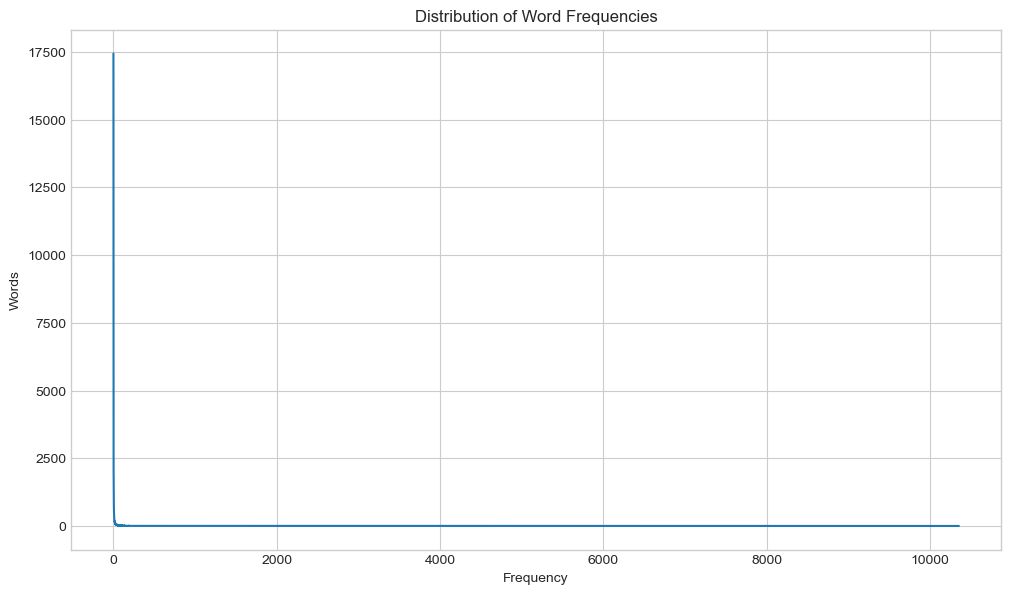

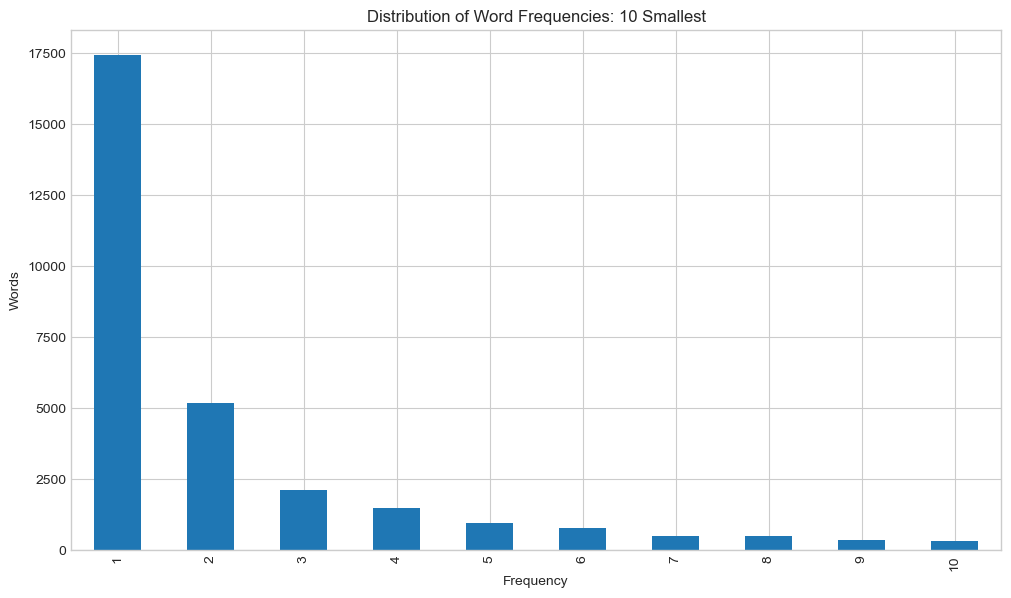



Preprocessing succesfully completed.




In [62]:
preprocess_text(first_input_folder, theses, inter_output_folder, verbose = True)


After launching the function at $17:00$, it ended at $17:48$.

***Disclaimer Note:*** <br>
Dropped `118.su.pdf` as it kept making the function freeze on any computer we tried on.

We now have $124$ MSc.

**End Result:**

We have successfully pre-processed $124$ MSc theses for LDA.

## Step 4) Making the corpus

For this we use the customly designed  `CorpusMaker` class, which includes three methods.

```python

CorpusMaker.make_corpus: 'Sets up the corpus, returns corpus, dictionary, ID mapping and texts. The returns are pickled and automatically saved to folder DICT_CORP.'
CorpusMaker.show_top_words: 'Prints selected amount of most frequent words per thesis.'
CorpusMaker.make_wordcloud: 'Generates word cloud image. The image is automatically saved to the Plots folder.'


In [2]:
# Import the class
from corpus_maker import CorpusMaker

In [3]:
# Inspect the class
CorpusMaker?

Init signature: CorpusMaker(input_folder)
Docstring:     
A class used for turning the filtered LvB MSc theses into a corpus. Generally, this class can also be used to generate a corpus from any set of .txt files that have already gone through standard NLP preprocessing. 

Outputs are saved as pickle files in automatically generated folder DICT_CORP.

Args:
    input_folder (str): The folder containing the filtered MSc theses. (Should set to the output of the preprocessing function)
    
Attributes:
    dictionary: A dictionary generated using Gensim.
    dictionary_token2id: A mapping of tokens to IDs.
    corpus: BoW corpus generated from the theses. 
    texts: All tokens (used for coherence later on)
    dates: Returns dates list for theses
    
Methods:
    make_corpus: Processes the filtered theses texts, drops rare words overall, creates corpus.
    show_top_words: Prints the most frequent words per thesis in the corpus
    make_wordcloud: Generates a wordcloud image from the co

In [4]:
corp_maker = CorpusMaker(input_folder = 'Filtered Theses')

In [5]:
dictionary, dictionary_token2id, corpus, texts, dates = corp_maker.make_corpus()

Creating corpus...
After removing 27781 rare words, total amount of words in the preprocessed texts decreased from 820920 to 793139
Corpus succesfully created.


In [6]:
corp_maker.show_top_words(amount = 5)

Thesis 1
estimate: 144
price: 126
bandwidth: 124
use: 107
option: 91

Thesis 2
portfolio: 155
return: 152
mean: 136
variance: 130
frontier: 126

Thesis 3
network: 165
function: 159
set: 81
neural: 75
neuron: 65

Thesis 4
learn: 111
md: 70
fic: 61
process: 54
booklet: 54

Thesis 5
course: 157
factor: 122
variable: 100
data: 87
student: 86

Thesis 6
md: 132
excel: 124
rex: 115
add: 96
statistical: 76

Thesis 7
function: 219
basis: 151
data: 132
spline: 129
use: 88

Thesis 8
function: 120
evalarg: 118
functional: 98
matrix: 86
coef: 86

Thesis 9
model: 250
option: 181
price: 156
hedge: 130
volatility: 125

Thesis 10
distribution: 130
density: 123
ic: 108
var: 96
estimate: 83

Thesis 11
tree: 175
data: 91
node: 91
decision: 64
class: 62

Thesis 12
model: 138
time: 94
iv: 93
one: 90
function: 80

Thesis 13
copula: 215
distribution: 91
portfolio: 47
function: 42
risk: 41

Thesis 14
copula: 259
parameter: 175
panel: 112
dependence: 98
jump: 92

Thesis 15
return: 396
market: 206
portfolio: 174

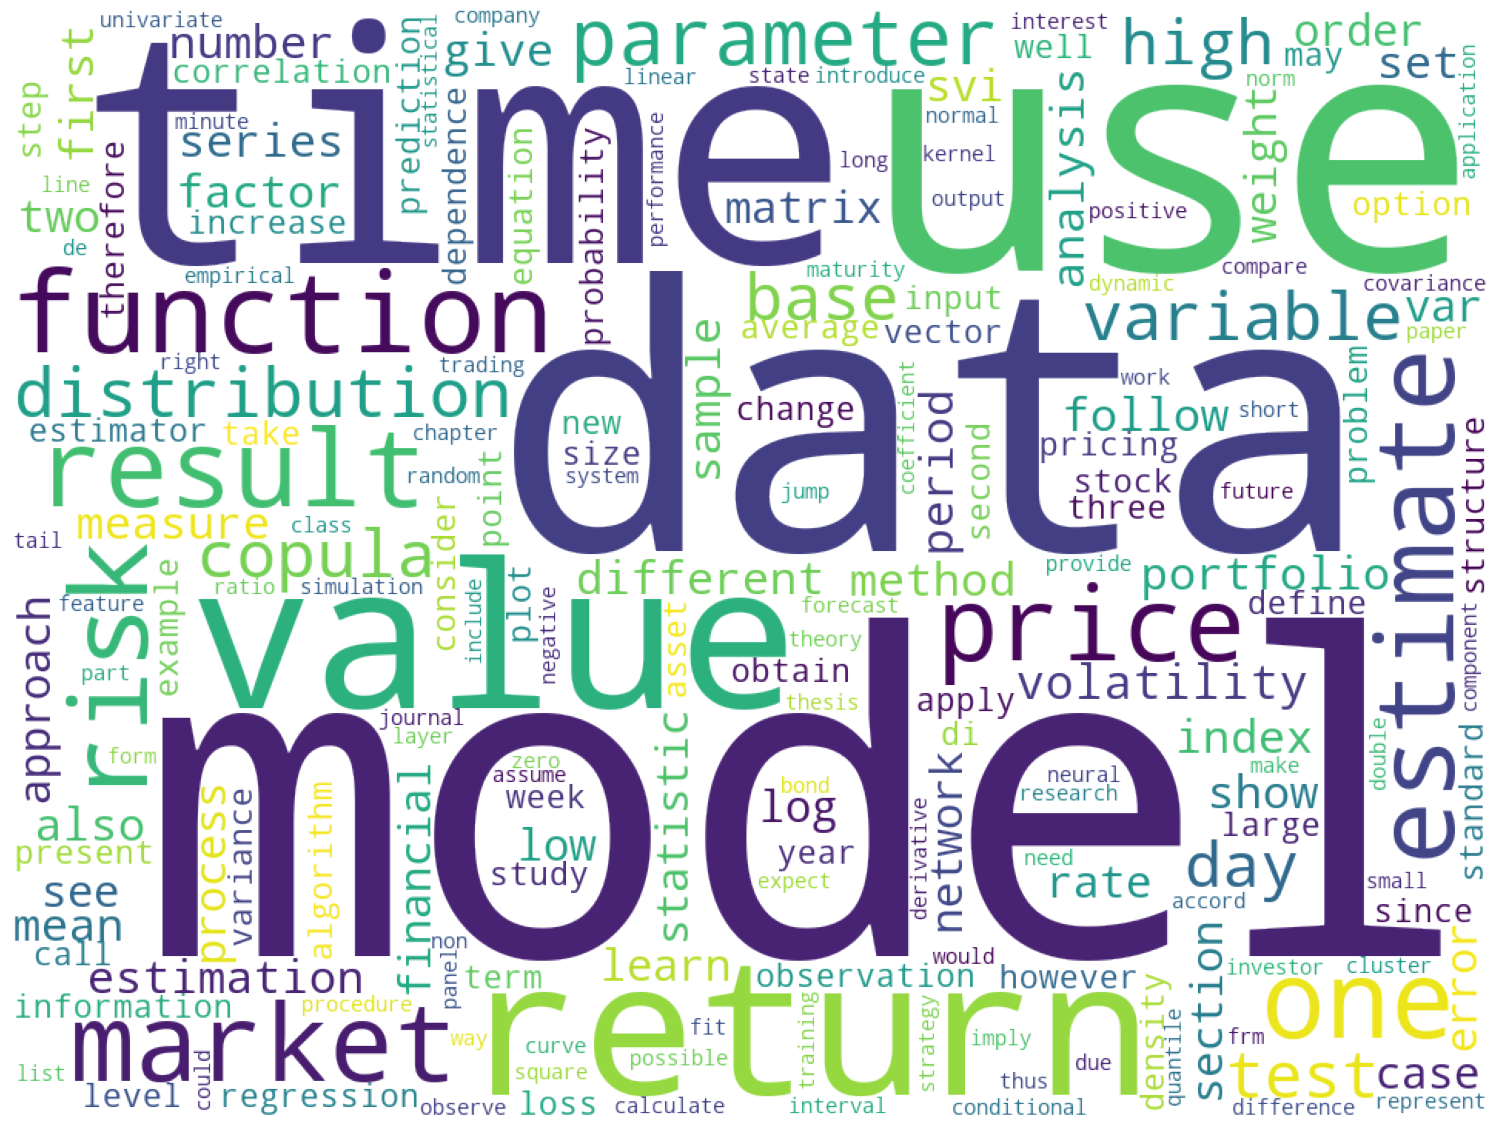

In [7]:
corp_maker.make_wordcloud()

***Disclaimer note:***

We had to manually crop thesis by `aydinli` in half since $50\%$ of the document was code.

Also, we had to manually drop two theses: `105.du-moulinet-d-hardemare.pdf` and `121.ashu.pdf`, because there was a problem with underlying text in the file, which could not be read.

We now have $122$ theses in the corpus.


## Step 5) LDA Class

We have defined a custom LDA class `LDA`, aimed at designing a simple,  user-friendly interface for carrying out LDA with grid search. 

As arguments, it takes `corpus`, `dictionary`, `texts` generated by the `CorpusMaker` class.

The class includes five methods:

```python

LDA.simple_fit(): 'Fits an LDA model with user\'s specifications.'
LDA.gird_search(): 'Carries out a grid search per user\'s specified parameters.'
LDA.lineplot_scores(): 'Plots coherence and perplexity scores per alpha and beta values and topic numbers.'
LDA.build_best_model(): 'Fits the best model obtained in grid search.'
LDA.viz(): 'Visualizes model obtained by either simple_fit or build_best_model methods.'


In [2]:
from LDA_with_Grid import LDA

C:\Users\baltt\anaconda3\lib\site-packages\numexpr\expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
C:\Users\baltt\anaconda3\lib\site-packages\numexpr\expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')


In [3]:
LDA?

Init signature: LDA(corpus, dictionary, texts)
Docstring:     
A custom LDA interface designed to carry out a grid search, find the best model and vizualize it. 
Grid search carried out per coherence instead of perplexity, as optimizing for the latter may not lead to "human interpretable topics."

Args:

    corpus: A bag of words corpus (Already generated by CorpusMaker)
    dictionary: A gensim dictionary (Already generated by CorpusMaker)
    texts: All tokens (Already generated by CorpusMaker)
    
How to use:
    
    MSc_LDA = LDA(corpus, dictionary, texts) <-- initializes the class
    m = MSc_LDA.simple_fit() <-- fits one model with custom specs
    MSc_LDA.grid_search(n_topics, alphas, betas) <-- conducts grid search
    MSc_LDA.lineplot_scores() <-- plots coherence scores from grid search rounds
    m = MSc_LDA.build_best_model() <-- fits best model
    MSc_LDA.viz() <-- vizualizes best/simple model
    
File:           d:\seafile\моя библиотека\2 semester\deda\github\bacha f

### Using the `.simple_fit()`

*Note:* It is possible to run the code below directly by opening the pickled files with the code, essentially skipping the scraping and automated, as well as manual pre-processing steps.

```python
import pickle

with open('DICT_CORP/corpus.pkl', 'rb') as file:
    corpus = pickle.load(file)
    
with open('DICT_CORP/dictionary_token2id.pkl', 'rb') as file:
    dictionary_token2id = pickle.load(file)
    
with open('DICT_CORP/dictionary.pkl', 'rb') as file:
    dictionary = pickle.load(file)
    
with open('DICT_CORP/texts.pkl', 'rb') as file:
    texts = pickle.load(file)


In [4]:
# Copy the code here if needed
import pickle

with open('DICT_CORP/corpus.pkl', 'rb') as file:
    corpus = pickle.load(file)
    
with open('DICT_CORP/dictionary_token2id.pkl', 'rb') as file:
    dictionary_token2id = pickle.load(file)
    
with open('DICT_CORP/dictionary.pkl', 'rb') as file:
    dictionary = pickle.load(file)
    
with open('DICT_CORP/texts.pkl', 'rb') as file:
    texts = pickle.load(file)

with open('DICT_CORP/dates.pkl', 'rb') as file:
    dates = pickle.load(file)

In [5]:
# Initialize
MSc_LDA = LDA(corpus, dictionary, texts)

In [6]:
# Set up a single model with ten topics, alpha of 
n_top = 10
alpha_val = 'symmetric'
beta_val = 0.6

simple_m = MSc_LDA.simple_fit(n_top = n_top,
                             alpha_val = alpha_val,
                             beta_val = beta_val)



Coherence Score is: 0.45728611221078974
Perplexity Score is: -7.572008622699236


See the topics:
(0, '0.015*"model" + 0.010*"data" + 0.010*"sentiment" + 0.009*"use" + 0.009*"network" + 0.009*"learn" + 0.009*"time" + 0.008*"base" + 0.006*"training" + 0.006*"layer"')
(1, '0.015*"model" + 0.009*"copula" + 0.008*"data" + 0.007*"double" + 0.006*"use" + 0.005*"variable" + 0.005*"value" + 0.004*"factor" + 0.004*"result" + 0.004*"one"')
(2, '0.023*"return" + 0.015*"private" + 0.014*"market" + 0.014*"equity" + 0.012*"risk" + 0.010*"factor" + 0.009*"company" + 0.008*"test" + 0.008*"beta" + 0.008*"public"')
(3, '0.033*"frm" + 0.016*"risk" + 0.012*"financial" + 0.011*"model" + 0.011*"candidate" + 0.009*"market" + 0.009*"systemic" + 0.009*"institution" + 0.008*"measure" + 0.008*"america"')
(4, '0.013*"model" + 0.009*"estimate" + 0.009*"distribution" + 0.008*"copula" + 0.007*"time" + 0.007*"value" + 0.007*"use" + 0.007*"return" + 0.007*"parameter" + 0.007*"function"')
(5, '0.015*"option" + 0.015*

In [7]:
# Vizualize model
MSc_LDA.viz(model_type = 'simple') 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.061990  0.009620       1        1  29.464100
0      0.029429 -0.044425       2        1  12.787754
5     -0.062850  0.027010       3        1  11.335997
6      0.020865 -0.047397       4        1   9.324491
1     -0.042202 -0.059716       5        1   8.984625
8     -0.052487 -0.098696       6        1   8.741901
2     -0.000115  0.128258       7        1   5.665830
3     -0.061665  0.092672       8        1   5.304979
9      0.012804 -0.020533       9        1   5.183079
7      0.218211  0.013208      10        1   3.207244, topic_info=            Term         Freq        Total Category  logprob  loglift
3316         frm  1392.000000  1392.000000  Default  30.0000  30.0000
895         risk  3628.000000  3628.000000  Default  29.0000  29.0000
10517        svi  1250.000000  1250.000000  Default  28.0000  28.0000
783    portfolio  2095.000000  2095.000000  Default  27.0000  27.0000
886       return  4155.000000  4155.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
875      require    81.535032   425.311872  Topic10  -5.7430   1.7880
517        index    95.767947  1518.650336  Topic10  -5.5821   0.6761
1097         use   110.380840  5132.933636  Topic10  -5.4401  -0.3997
801        price    99.448487  3267.452772  Topic10  -5.5444  -0.0524
886       return    95.054123  4155.294950  Topic10  -5.5895  -0.3379

[704 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1175      1  0.165607   ac
1175      3  0.004476   ac
1175      4  0.017903   ac
1175      5  0.044759   ac
1175      6  0.035807   ac
...     ...       ...  ...
1172      6  0.075431   zu
1172      7  0.012572   zu
1172      8  0.025144   zu
1172      9  0.046097   zu
1172     10  0.314295   zu

[3961 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 6, 7, 2, 9, 3, 4, 10, 8])

### Using the `.grid_search()` and `.build_best_model()`

*Note to Timur:* The grid parameter set up in the block below is just for demonstrational purposes, 

For better grid search try (even consider smaller steps with alphas and betas):

```python

n_topics = list(range(2, 20))
alphas = np.arange(0.1, 1, 0.1).tolist()
betas = np.arange(0.1, 1, 0.1).tolist()



#### 1st iteration

In [8]:

# Set up parameter grid 
#n_topics = list(range(2, 10))
#alphas = np.arange(0.1, 1, 0.2).tolist()
#betas = np.arange(0.1, 1, 0.2).tolist()
n_topics = range(2,30)
alpha = ['symmetric']
beta = ['auto']

## I append these two by hand to the gird
# because I'm not skilled enough to have included them in the upper lines of code
#alphas.append('symmetric')
#betas.append('auto')


**About the verbose argument:**

The verbose argument here just activates print statements that show the coherence score per round of the search. Even if set to false, the outputs will be saved as a CSV file. 

In [14]:
# Do the grid search
MSc_LDA.grid_search(n_topics, alpha, beta, verbose = True)

# Setting verbose = True ensures the function output 

Number of topics: 2; alpha: symmetric; beta: auto; Achieved coherence score: 0.30086049532782744
Number of topics: 3; alpha: symmetric; beta: auto; Achieved coherence score: 0.36847240244584767
Number of topics: 4; alpha: symmetric; beta: auto; Achieved coherence score: 0.34993759504177147
Number of topics: 5; alpha: symmetric; beta: auto; Achieved coherence score: 0.41829169883902073
Number of topics: 6; alpha: symmetric; beta: auto; Achieved coherence score: 0.417886781747455
Number of topics: 7; alpha: symmetric; beta: auto; Achieved coherence score: 0.41922681947260393
Number of topics: 8; alpha: symmetric; beta: auto; Achieved coherence score: 0.40887211935779955
Number of topics: 9; alpha: symmetric; beta: auto; Achieved coherence score: 0.4321437531856022
Number of topics: 10; alpha: symmetric; beta: auto; Achieved coherence score: 0.4048149908730025
Number of topics: 11; alpha: symmetric; beta: auto; Achieved coherence score: 0.45273185989626175
Number of topics: 12; alpha: sym

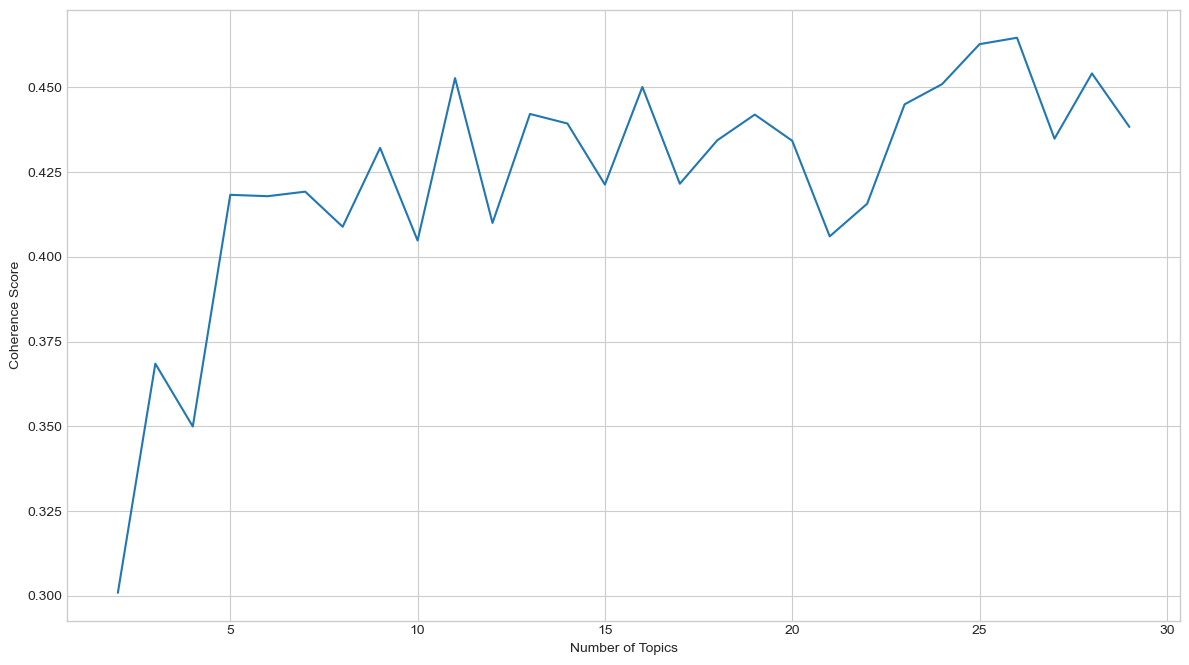

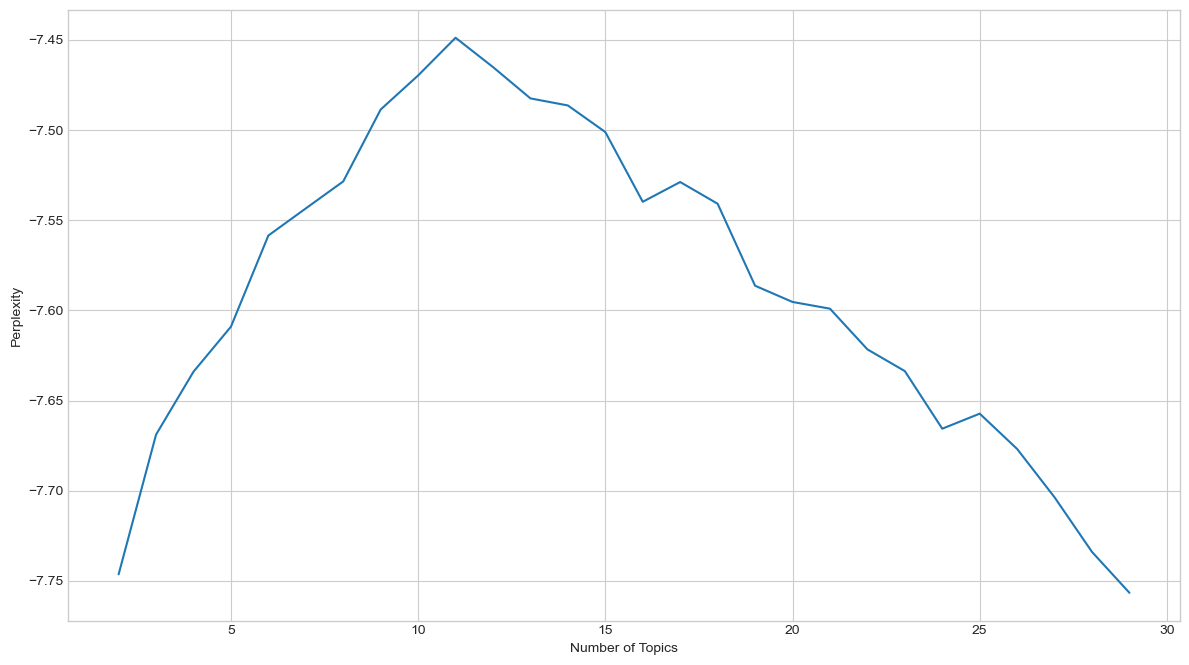

In [15]:
# Plot the scores
MSc_LDA.lineplot_scores()

***Disclaimer Note:***
The plotting functionality needs improving as it does not reflect alpha and beta values.

In [16]:
# call best model
best_m = MSc_LDA.build_best_model()

(12, '0.034*"region" + 0.033*"landkreis" + 0.031*"spatial" + 0.028*"kreis" + 0.023*"mortality" + 0.019*"stadt" + 0.018*"kreisfreie" + 0.013*"death" + 0.013*"smr" + 0.011*"age"')
(21, '0.089*"frm" + 0.029*"candidate" + 0.023*"financial" + 0.022*"systemic" + 0.022*"america" + 0.022*"risk" + 0.018*"institution" + 0.017*"europe" + 0.015*"model" + 0.014*"measure"')
(9, '0.019*"model" + 0.017*"network" + 0.012*"learn" + 0.010*"neural" + 0.010*"use" + 0.010*"time" + 0.009*"training" + 0.009*"recipe" + 0.007*"input" + 0.007*"set"')
(23, '0.024*"sentiment" + 0.012*"data" + 0.011*"use" + 0.011*"model" + 0.010*"base" + 0.010*"word" + 0.009*"article" + 0.009*"news" + 0.008*"analysis" + 0.008*"learn"')
(2, '0.031*"private" + 0.030*"return" + 0.027*"equity" + 0.019*"company" + 0.017*"public" + 0.016*"test" + 0.014*"beta" + 0.013*"market" + 0.013*"firm" + 0.011*"risk"')
(3, '0.017*"market" + 0.015*"index" + 0.009*"risk" + 0.009*"parameter" + 0.009*"high" + 0.008*"time" + 0.007*"estimate" + 0.007*"cc"

In [17]:
# Viz best model by setting model_type = 'best'
MSc_LDA.viz(model_type = 'best')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
20     0.059467 -0.013396       1        1  12.567768
22     0.048244  0.094191       2        1  10.235161
5      0.051802 -0.085953       3        1   7.621809
9      0.089078  0.146802       4        1   5.691292
4      0.027989 -0.094501       5        1   5.360103
14     0.023229 -0.011009       6        1   5.142565
25     0.034373 -0.082834       7        1   5.020095
15     0.002135 -0.087713       8        1   4.308133
10     0.087806 -0.064717       9        1   4.167594
13     0.004960 -0.188391      10        1   3.954354
23     0.081636  0.124727      11        1   3.831041
8      0.005689  0.102568      12        1   3.576508
2      0.077699 -0.002615      13        1   3.459571
19    -0.016279  0.039802      14        1   3.289096
16     0.101179 -0.057225      15        1   3.268209
3      0.077187  0.003660      16        1   3.251356
18     0.052361  0.067005      17        1   3.213556
17     0.095057  0.150836      18        1   2.793739
24     0.019740 -0.025288      19        1   2.444174
21     0.080664 -0.080639      20        1   1.735392
0      0.062407  0.134241      21        1   1.480193
11    -0.102864 -0.082677      22        1   1.365923
6     -0.093482 -0.113530      23        1   1.209143
12    -0.194813  0.000348      24        1   0.610466
1     -0.331211  0.074693      25        1   0.300562
7     -0.344054  0.051613      26        1   0.102196, topic_info=                Term          Freq         Total Category  logprob  loglift
4475          copula   2925.000000   2925.000000  Default  30.0000  30.0000
659            model  10313.000000  10313.000000  Default  29.0000  29.0000
3316             frm   1267.000000   1267.000000  Default  28.0000  28.0000
10517            svi   1499.000000   1499.000000  Default  27.0000  27.0000
238              day   2622.000000   2622.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
357        estimator      6.423691   1424.989097  Topic26  -4.8377   1.4841
708    nonparametric      4.385906    315.796148  Topic26  -5.2193   2.6093
217            cover      3.682849    221.471149  Topic26  -5.3940   2.7894
967           smooth      3.818912    494.241001  Topic26  -5.3578   2.0230
177        condition      3.410103    339.329374  Topic26  -5.4710   2.2858

[1839 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
5206       1  0.012145  abnormal
5206      11  0.777307  abnormal
5206      13  0.194327  abnormal
4684      19  0.936274  abstract
1175       1  0.936534        ac
...      ...       ...       ...
1172      17  0.015484        zu
1172      18  0.379367        zu
1172      19  0.030969        zu
1172      21  0.007742        zu
10211     16  0.866456        zy

[8060 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 23, 6, 10, 5, 15, 26, 16, 11, 14, 24, 9, 3, 20, 17, 4, 19, 18, 25, 22, 1, 12, 7, 13, 2, 8])

#### 2nd iteration

In [20]:
# Set up parameter grid 

n_topics = [11]
alphas = np.arange(0.1, 1, 0.2).tolist()
betas = np.arange(0.1, 1, 0.2).tolist()

## I append these two by hand to the gird
# because I'm not skilled enough to have included them in the upper lines of code
alphas.append('symmetric')
betas.append('auto')

In [26]:
#remove the assigned best score from the previous iteration
MSc_LDA.best_score = -1

# Do the grid search
MSc_LDA.grid_search(n_topics, alphas, betas, verbose = True)

# Setting verbose = True ensures the function output 

Number of topics: 11; alpha: 0.1; beta: 0.1; Achieved coherence score: 0.44880395876257384
Number of topics: 11; alpha: 0.1; beta: 0.30000000000000004; Achieved coherence score: 0.44194649343823916
Number of topics: 11; alpha: 0.1; beta: 0.5000000000000001; Achieved coherence score: 0.45664976647658323
Number of topics: 11; alpha: 0.1; beta: 0.7000000000000001; Achieved coherence score: 0.45760044102391473
Number of topics: 11; alpha: 0.1; beta: 0.9000000000000001; Achieved coherence score: 0.45904744970453704
Number of topics: 11; alpha: 0.1; beta: auto; Achieved coherence score: 0.45273185989626175
Number of topics: 11; alpha: 0.30000000000000004; beta: 0.1; Achieved coherence score: 0.44880395876257384
Number of topics: 11; alpha: 0.30000000000000004; beta: 0.30000000000000004; Achieved coherence score: 0.44194649343823916
Number of topics: 11; alpha: 0.30000000000000004; beta: 0.5000000000000001; Achieved coherence score: 0.4569940189759777
Number of topics: 11; alpha: 0.3000000000

In [27]:
# call best model
best_m = MSc_LDA.build_best_model()

(0, '0.014*"model" + 0.010*"data" + 0.009*"use" + 0.009*"sentiment" + 0.009*"network" + 0.009*"learn" + 0.007*"base" + 0.007*"time" + 0.006*"training" + 0.006*"layer"')
(1, '0.013*"model" + 0.012*"copula" + 0.006*"cdo" + 0.005*"item" + 0.005*"tranche" + 0.005*"exam" + 0.004*"landkreis" + 0.004*"spatial" + 0.004*"exercise" + 0.004*"csv"')
(2, '0.020*"return" + 0.014*"private" + 0.013*"equity" + 0.012*"market" + 0.012*"risk" + 0.011*"factor" + 0.008*"company" + 0.007*"asset" + 0.007*"test" + 0.007*"beta"')
(3, '0.033*"frm" + 0.015*"risk" + 0.012*"financial" + 0.010*"candidate" + 0.009*"model" + 0.009*"systemic" + 0.009*"market" + 0.009*"institution" + 0.008*"america" + 0.008*"measure"')
(4, '0.014*"model" + 0.009*"estimate" + 0.008*"distribution" + 0.007*"copula" + 0.007*"value" + 0.007*"use" + 0.007*"data" + 0.007*"return" + 0.007*"function" + 0.007*"time"')
(5, '0.013*"time" + 0.011*"series" + 0.010*"data" + 0.005*"ar" + 0.005*"temperature" + 0.003*"md" + 0.003*"mining" + 0.003*"emotio

In [28]:
# Viz best model by setting model_type = 'best'
MSc_LDA.viz(model_type = 'best')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.047835  0.059564       1        1  35.798619
0     -0.063382 -0.021824       2        1  12.557705
6     -0.008979 -0.013517       3        1   9.870152
10    -0.063270  0.062108       4        1   9.329410
8      0.097931  0.030204       5        1   6.999454
3     -0.058652  0.066015       6        1   5.228360
2     -0.088288  0.007305       7        1   5.168251
9     -0.029959 -0.001169       8        1   4.559276
5      0.118231 -0.000104       9        1   4.353896
1      0.167587  0.012571      10        1   3.151854
7     -0.023384 -0.201154      11        1   2.983023, topic_info=           Term         Freq        Total Category  logprob  loglift
4475     copula  2383.000000  2383.000000  Default  30.0000  30.0000
3316        frm  1374.000000  1374.000000  Default  29.0000  29.0000
895        risk  3575.000000  3575.000000  Default  28.0000  28.0000
783   portfolio  2055.000000  2055.000000  Default  27.0000  27.0000
886      return  4046.000000  4046.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
625      market   117.424627  3230.513700  Topic11  -5.3057   0.1976
517       index    89.578573  1457.304573  Topic11  -5.5764   0.7230
1097        use    97.570963  4886.629784  Topic11  -5.4909  -0.4014
801       price    89.066246  3069.094232  Topic11  -5.5821  -0.0275
886      return    85.429660  4046.113292  Topic11  -5.6238  -0.3456

[725 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1175       1  0.207188         ac
1175       2  0.004504         ac
1175       3  0.018016         ac
1175       4  0.004504         ac
1175       5  0.027025         ac
...      ...       ...        ...
12643      4  0.029373  zbonakova
12643      5  0.029373  zbonakova
12643      6  0.763696  zbonakova
12643      9  0.029373  zbonakova
12643     10  0.029373  zbonakova

[4986 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 7, 11, 9, 4, 3, 10, 6, 2, 8])

# Dynamic Topic Modelling

In [29]:
#creates slice for DTM
#slice is a number of topics in a time period (here: in a year)

#NOTE: this version of slice takes too much time to run for ldaseqmodel
#      better use the version with year batches (see below)
year_counts = {}
for item in dates:
    year = item[0]
    if year in year_counts:
        year_counts[year] += 1
    else:
        year_counts[year] = 1

time_slice = list(year_counts.values())

time_slice

[1, 2, 5, 11, 2, 6, 2, 10, 2, 1, 9, 5, 8, 16, 4, 5, 8, 7, 6, 7, 4, 1]

In [30]:
year_batches = [range(2002,2009), range(2009,2016), range(2016, 2020), range(2020, 2024)]
year_batches = [list(item) for item in year_batches]

print(year_batches)

batches_counts = {}
for index, year_batch in enumerate(year_bathches):
    batches_counts[index] = 0
    
for key, value in year_counts.items():
    for index, batch in enumerate(year_batches):
        if int(key) in batch:
            batches_counts[index] += value
            
print(sum(batches_counts.values()))
batches_counts

[[2002, 2003, 2004, 2005, 2006, 2007, 2008],
 [2009, 2010, 2011, 2012, 2013, 2014, 2015],
 [2016, 2017, 2018, 2019],
 [2020, 2021, 2022, 2023]]

In [39]:
from gensim.models import LdaSeqModel

# a typo in the ldaseqmodel documentation: initialize accepts value "ldamodel" not "lda_model"
ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=list(batches_counts.values()),
                     num_topics=MSc_LDA.best_params[0], alphas =  MSc_LDA.best_params[1], initialize = 'ldamodel',
                     lda_model = MSc_LDA.best_model, random_state = 66)

In [40]:
temp_file = "LDAModels_Gensim/DTM_model.gensim"
ldaseq.save(temp_file)

# for given time, the distriibution of each topic 
ldaseq.print_topics(time=1)

[[('model', 0.014005542809530609),
  ('network', 0.013727063224986995),
  ('use', 0.009370530780721144),
  ('data', 0.009321309729269141),
  ('neural', 0.00802436365471924),
  ('learn', 0.007066621761689911),
  ('set', 0.006897894460576503),
  ('layer', 0.006617272845295547),
  ('time', 0.006549779036734894),
  ('input', 0.006306357741053037),
  ('training', 0.00592971957448906),
  ('function', 0.005883311084155509),
  ('sentiment', 0.005467196384846509),
  ('value', 0.005242372983374878),
  ('prediction', 0.005129163334561604),
  ('one', 0.005104539429949271),
  ('base', 0.0050270709433826955),
  ('output', 0.0048493610704385065),
  ('article', 0.004492384624635602),
  ('return', 0.004476717414125254)],
 [('model', 0.02663587830470165),
  ('copula', 0.018768173364739175),
  ('factor', 0.00865892221288575),
  ('correlation', 0.008488979857584508),
  ('data', 0.008237633697029777),
  ('item', 0.007267309926638484),
  ('cdo', 0.00707731017956711),
  ('default', 0.0060574108795701555),
  

In [85]:
# for given topic the word distribution over time
DTM_topics = []

for topic in range(0,MSc_LDA.best_params[0]):
    DTM_topics.append(ldaseq.print_topic_times(topic=topic, top_terms=30))

In [87]:
DTM_topics[0]

[[('model', 0.013830049244010718),
  ('network', 0.013754892866623113),
  ('use', 0.009312119710953451),
  ('data', 0.009206645248148872),
  ('neural', 0.009036702216094731),
  ('learn', 0.006986850414046119),
  ('input', 0.0069579057183607644),
  ('set', 0.006914153379902554),
  ('layer', 0.006765084544914878),
  ('time', 0.0064611402664899896),
  ('training', 0.006121848447713039),
  ('function', 0.005945358010493736),
  ('sentiment', 0.005263042275873614),
  ('value', 0.005213362990795907),
  ('article', 0.005082637508994419),
  ('prediction', 0.005022474020375296),
  ('one', 0.004976371482791058),
  ('base', 0.004914142911120125),
  ('output', 0.004844538563982004),
  ('return', 0.004379512877572182),
  ('word', 0.004106487115394596),
  ('error', 0.0039886927059324525),
  ('lstm', 0.003913374986358788),
  ('market', 0.0037822134610147043),
  ('price', 0.0037244682566931605),
  ('result', 0.0034583881707245987),
  ('weight', 0.003424126631719622),
  ('energy', 0.0033706842553237614)

In [88]:
import pandas as pd

#the same as year_batches but for greater looking visuals
#turns a batch from a list to a str "begin_year - end_year"
time_periods = [f"{period[0]}-{period[-1]}" for period in year_batches]

def topic_time(DTM_topic,time_periods):  
    dfs = []
    for period, topic_dist in enumerate(DTM_topic):
        df = pd.DataFrame(topic_dist, columns=["Word", f"Period {period+1}"])
        dfs.append(df)

    # Merge the DataFrames based on the "Word" column
    topic_words_time = pd.concat(dfs).groupby("Word").sum()

    # Fill NaN values with zeros
    topic_words_time.fillna(0, inplace=True)
    topic_words_time.columns = time_periods
    
    # Display the resulting DataFrame
    return topic_words_time

In [89]:
topics_words_time = []

for topic in DTM_topics:
    topics_words_time.append(topic_time(topic,time_periods))
    
topics_words_time[7]

,2002-2008,2009-2015,2016-2019,2020-2023
Word,,,,
address,0.006004,0.006108,0.006309,0.006544
asset,0.005754,0.005728,0.005867,0.005936
bitcoin,0.008398,0.008444,0.007949,0.006781
blockchain,0.007481,0.007741,0.008230,0.008714
coin,0.007545,0.007672,0.007865,0.008059
constituent,0.006213,0.006100,0.005852,0.005658
contract,0.009203,0.009354,0.009681,0.010025
crix,0.013204,0.013252,0.013165,0.013040
crypto,0.013261,0.014114,0.014608,0.013360


In [90]:
import os

# Create a directory for saving the CSV files
directory = "topics_words_time"
if not os.path.exists(directory):
    os.makedirs(directory)

# Iterate over each element in topics_words_time
for i, df in enumerate(topics_words_time):
    # Generate the file path for the current topic
    file_path = os.path.join(directory, f"topic{i+1}_words_time.csv")

    # Save the dataframe as a CSV file
    df.to_csv(file_path)

In [114]:
k = 5
top_k_words_topics_overtime = []

#takes top k words from the dataframe for each topic
# if the top k changes over periods, it includes all words that have ever been in top k
for topic_df in topics_words_time:
    topic_topk_words = set()
    for period in topic_df.columns:
        #gets top 5 words for each period
        topic_topk_words_in_period = list(topic_df[period].sort_values(ascending=False)[:k].index)
        topic_topk_words.update(topic_topk_words_in_period)
    print(topic_topk_words)
    top_k_words_topics_overtime.append(topic_df[topic_df.index.isin(topic_topk_words)])

top_k_words_topics_overtime[3]

{'use', 'network', 'neural', 'model', 'data'}
{'factor', 'correlation', 'model', 'data', 'copula'}
{'bond', 'risk', 'return', 'model', 'market', 'factor'}
{'frm', 'covar', 'risk', 'measure', 'model', 'financial'}
{'distribution', 'estimation', 'estimate', 'model', 'copula'}
{'time', 'model', 'ar', 'series', 'use', 'data'}
{'variable', 'value', 'use', 'model', 'data'}
{'currency', 'index', 'value', 'crypto', 'crix', 'function'}
{'svi', 'di', 'week', 'day', 'model'}
{'cluster', 'matrix', 'return', 'portfolio', 'double', 'data'}
{'time', 'price', 'volatility', 'option', 'model'}


,2002-2008,2009-2015,2016-2019,2020-2023
Word,,,,
covar,0.009877,0.009894,0.009677,0.009716
financial,0.014388,0.013100,0.010848,0.011207
frm,0.012384,0.012955,0.013992,0.015604
measure,0.010409,0.010158,0.009159,0.007981
model,0.017261,0.017285,0.016906,0.016985
risk,0.016543,0.016158,0.017057,0.016631


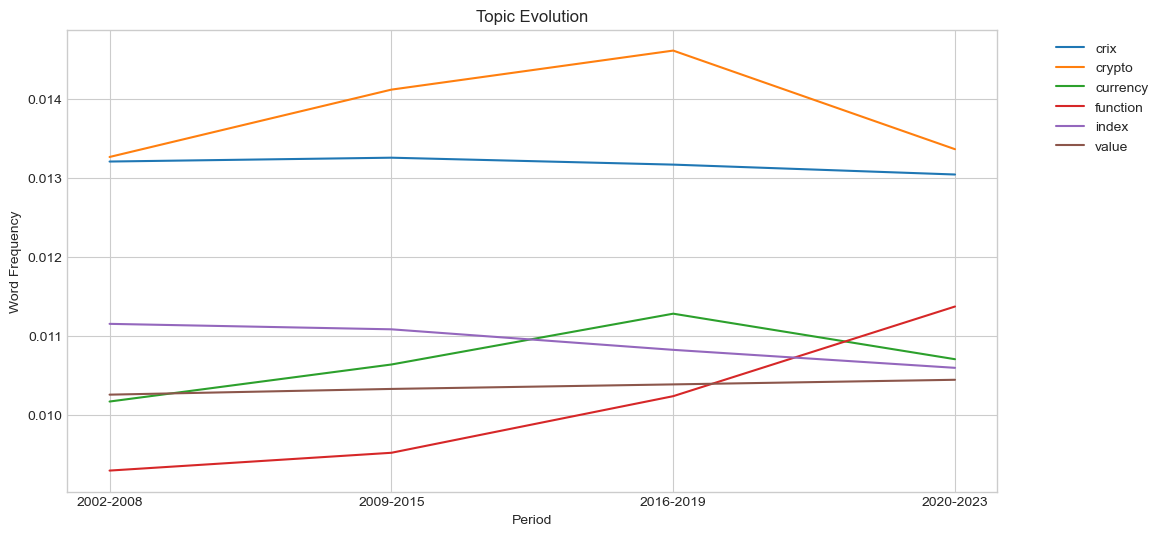

In [119]:
import matplotlib.pyplot as plt

# Plotting parameters
plt.figure(figsize=(12, 6))
plt.title('Topic Evolution')
plt.xlabel('Period')
plt.ylabel('Word Frequency')

# Iterate over each word
for word in top_k_words_topics_overtime[7].index:
    frequencies = top_k_words_topics_overtime[7].loc[word].values
    plt.plot(top_k_words_topics_overtime[7].columns, frequencies, label=word)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('plots/topic8_evolution.png')

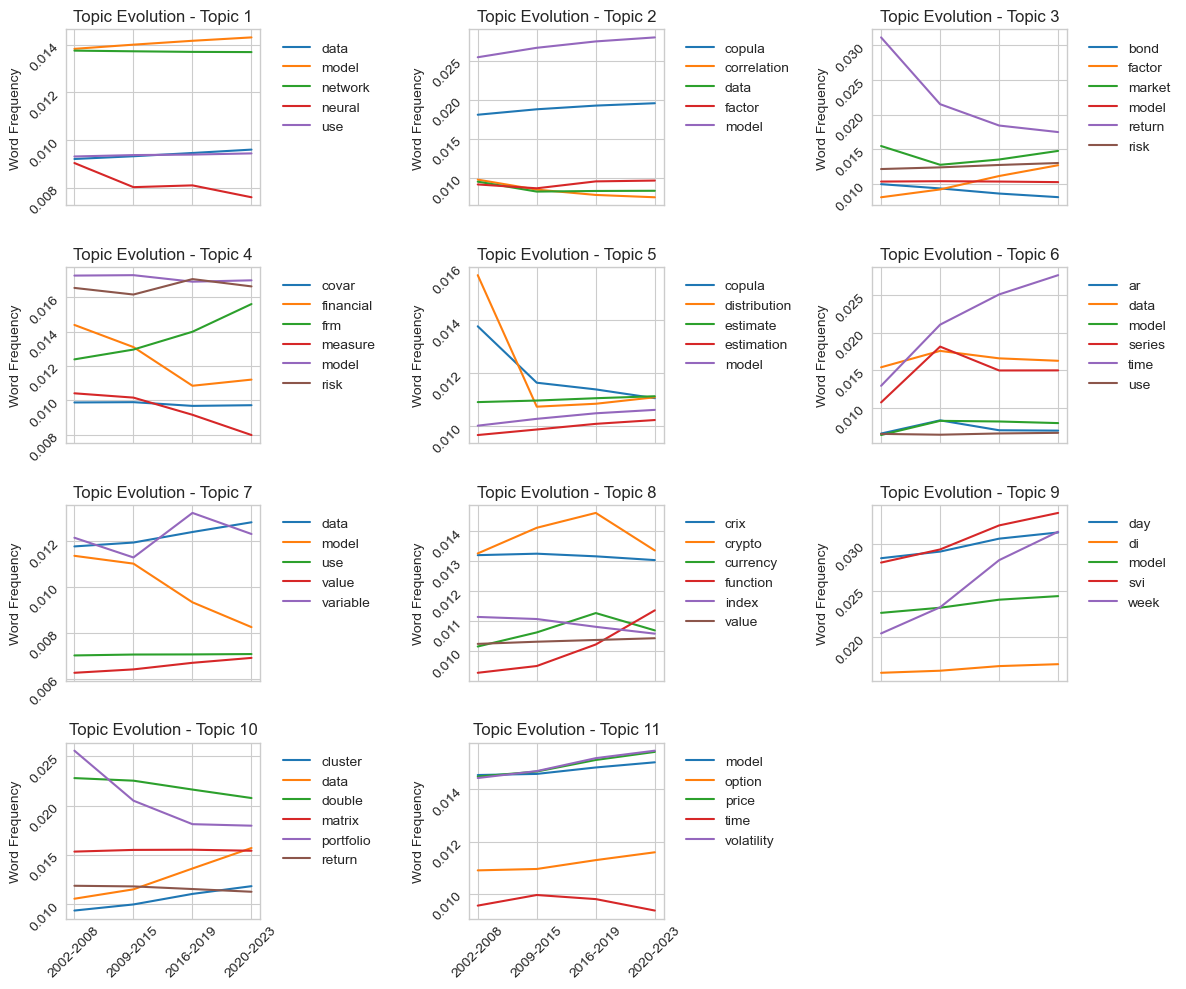

In [130]:
# Set the number of rows and columns for subplots
num_rows = 4
num_cols = 3

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 10), sharex=True)

# Reshape the axs array
axs = axs.reshape(-1)

# Iterate over each element in topics_words_time
for i, df in enumerate(top_k_words_topics_overtime):
    # Select the subplot for the current element
    ax = axs[i]

    # Plotting parameters for the current subplot
    ax.set_title(f'Topic Evolution - Topic {i+1}')
    #ax.set_xlabel('Period')
    ax.set_ylabel('Word Frequency')

    # Iterate over each word
    for word in df.index:
        frequencies = df.loc[word].values
        ax.plot(df.columns, frequencies, label=word)
    
    ax.tick_params(labelrotation=45)
    # Add legend and grid to the current subplot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)

axs.flat[-1].set_visible(False) # to remove last plot
# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('plots/topics_evolution.png')
# Show the figures
plt.show()